----
# Introduction to Data Science and Systems

## Self-study: Arrays, numpy and vectorisaiton

### Chapter 5: Numerical aspects¶

##### University of Glasgow - material prepared by John H. Williamson*; adapted to IDSS by BSJ.
 
 
$$\newcommand{\vec}[1]{{\bf #1}} 
\newcommand{\real}{\mathbb{R}}
\newcommand{\expect}[1]{\mathbb{E}[#1]}
\DeclareMathOperator*{\argmin}{arg\,min}
\newcommand{\vec}[1]{{\bf #1} } 
\newcommand{\examinable}{{\quad\quad\LARGE[\spadesuit]}}
\newcommand{\real}{\mathbb{R}}
\newcommand{\expect}[1]{\mathbb{E}[#1]}
\DeclareMathOperator*{\argmin}{arg\,min}
%\vec{x}
%\real
%\examinable
%\vec{x}
%\real
$$



---

## Summary <a class="tocSkip">
By the end of this chapter you should know:
* how IEEE 754 `float32` and `float64` numbers are represented
* how infinity and NaN are represented, how they occur and how they are used
* what roundoff error is and how it tends to be caused
* how to compare floating point numbers
* what machine epsilon is and how it is defined

In [1]:
import IPython.display
IPython.display.HTML("""
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>""")

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from jhwutils.float_inspector import print_shape_html, print_float, print_float_html
from jhwutils.matrices import show_boxed_tensor_latex, print_matrix
import jhwutils.image_audio as ia
import numpy as np
%matplotlib inline
plt.rc('figure', figsize=(8.0, 4.0), dpi=140)

c:\python\Anaconda3_37_201907\lib\site-packages\IPython\kernel\__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated since IPython 4.0.You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


# Example: when asteroids collide

<img src="imgs/asteroid.jpg">
*[Image credit: [NASA/JPL](https://www.jpl.nasa.gov/spaceimages/details.php?id=PIA00118)]*

You work at a satellite company, developing models of satellite behaviour for asteroid mining. Your boss asks you to model the movement of one of your mining satellites on an large asteroid with four small metal-rich asteroids orbiting it. Your satellite is supposed approach one of the small asteroids and whisk it off towards the mining station for operations.

You implement a simple physical model which calculates the interaction between the graviational fields of your satellite and the asteroids and it looks like it works fine:

In [2]:
from jhwutils.tkanvas import TKanvas

# array: x,y,dx,dy,mass
planets = np.array([
    [0, 0, 0, 0, 500],  # the big asteroid
    [10, 0, 0, -2., 5],
    [-10, 0, 0, 2., 5],
    [0, 10, 2, 0., 5],
    [0, -10, -2, 0., 5],
    [0, -11, -2.0, -0.3, 1.0],  # the satellite
])

# how far away we move the point before simulating
offset = np.array([0, 0])
#offset = np.array([1e14, 2e14])
planets[:, 0:2] += offset
sat_path = []

def draw_planets(kanvas):
    kanvas.clear()
    scale = 20
    positions = (planets[:, 0:2] - offset) * scale + np.array(
        [kanvas.cx, kanvas.cy])
    radii = planets[:, -1]**(0.2) * 5
    for i in range(len(planets)):
        if radii[i]==5.0:
            kanvas.circle(positions[i, 0], positions[i, 1],
                          radii[i], fill='red')
        else:
            kanvas.circle(positions[i, 0], positions[i, 1],
                          radii[i], fill='white')
        
    kanvas.rectangle(kanvas.w-40, kanvas.h-300, kanvas.w, 
                     kanvas.h-100, fill='gray')
    if len(sat_path)>2:        
        path = ((np.array(sat_path) - offset) *
        scale + np.array([kanvas.cx, kanvas.cy]))   
        kanvas.canvas.create_line(*(path.ravel()), 
                                  width=1, fill='red')


def simulate_planets(dt):
    
    for i in range(len(planets)):
        # accumulate force into this vector
        total_force = np.zeros(2, )
        for j in range(len(planets)):
            if i != j:
                d = planets[j][0:2] - planets[i][0:2]
                force = np.sqrt(np.sum(d * d))
                direction = d / force

                # this is totally inaccurate and
                # nothing like real physical forces!
                total_force += 3.0 * direction * planets[j][-1] / (
                    force**2 + 0.1)

        # integrate, Euler style
        dt = 0.05
        planets[i][2:4] += total_force[0:2] * dt * dt * 0.5
        planets[i][0:2] += planets[i][2:4] * dt
    sat_path.append(np.array(planets[-1][0:2]))


k = TKanvas(draw_fn=draw_planets, 
            tick_fn=simulate_planets,
            w=1000, h=1000)
%gui tk

## It's all relative, right?
Your boss is a stickler for detail and asks you to make to coordinates you are using correct, and that the centre of the asteroid is really 1 $\times10^{14}$m away from Earth. Since the gravitational simulation is just based on the *relative* distances of bodies, this makes no difference; you just need to remove the offset before drawing the results on screen.

You run the simulation again, with the offset added...

----


## Algebra: a loss of structure
The **algebraic properties** of operators on real numbers (associativity, distributivity, and commutativity) are *not* preserved with the representation of numbers that we use for computations. The approximations used to store these numbers efficiently for computational purposes means that:

$$ab \neq ba, a+b \neq b+a, \text{etc.}$$
$$a(b+c) \neq ab + bc$$
$$a(bc) \neq (ab)c$$

Of course, most of the time, a good representation will be very close to these properties and they will almost hold, or at least hold for many specific examples. *But they are not preserved in general.*

In [5]:
print(1e120 +  1e-120 + -1e120)
print(1e120  + -1e120 + 1e120)

0.0
1e+120


# Number types
There are different representations for numbers that can be stored in arrays. Of these, **integers** and **floating point numbers** are of most relevance. Integers are familiar in their operation, but floats have some subtlety.

## Integers
Integers represent whole numbers (no fractional part). They come in two varieties: signed and unsigned. In memory, these are (normally!) stored as binary 2's complement (for signed) or unsigned binary (for unsigned).

Most 64 bit systems support operations on at least the following integer types:

| name   | bytes | min                        | max                        |
|--------|-------|----------------------------|----------------------------|
| int8   | 1     | -128                       | 127                        |
| uint8  | 1     | 0                          | 255                        |
| int16  | 2     | -32,768                    | 32,767                     |
| uint16 | 2     | 0                          | 65,535                     |
| int32  | 4     | -2,147,483,648             | 2,147,483,647              |
| uint32 | 4     | 0                          | 4,294,967,295              |
| int64  | 8     | -9,223,372,036,854,775,808 | +9,223,372,036,854,775,807 |
| uint64 | 8     | 0                          | 18,446,744,073,709,551,615 |

An operation which exceeds the bounds of the type results in **overflow**. Overflows have behaviour that may be undefined; for example adding 8 to the int8 value 120 (exceeds 127; result might be 127, or -128, or some other number). In most systems you will ever see, the result will be to wrap around, computing the operation modulo the range of the integer type.

NumPy allows integer arrays, although we won't use them extensively:

In [6]:
int_array  = np.array([100,110,120], dtype=np.int8)
print(int_array)
print(int_array+20) # beware!im

[100 110 120]
[ 120 -126 -116]


In [7]:
uint_array  = np.array([100,110,120], dtype=np.uint8)
print(uint_array)

print(uint_array+20) # ok
print(uint_array+150) # wrap, but through 0 this time

[100 110 120]
[120 130 140]
[250   4  14]


# Floats


## Floating point representation
Integers have (very) limited range, and don't represent fractional parts of numbers. Floating point is the most common representation for numbers that may be very large or small, and where fractional parts are required. Most modern computing hardware supports floating point numbers directly in hardware.

(side note: floating point isn't **required** for fractional representation; *fixed point* notation can also be used, but is much less flexible in terms of available range. It is often faster on simple hardware like microcontrollers; however modern CPUs and GPUs have extremely fast floating point units)

<img src="imgs/die-labeled.jpg"> 

*[The die of the 8087, the first Intel hardware floating point unit. From http://www.righto.com/2018/09/two-bits-per-transistor-high-density.html]*

Unlike integers, floating point numbers have some surprising properties which can cause **numerical issues**. 


**All floating point numbers are is a compact way to represent numbers of very large range, by allowing a fractional number with a standardised range (*mantissa*, varies from 1.0 to just less than 2.0) with a scaling or stretching factor (*exponent*, varies in steps of powers of 2).**

<img src="imgs/floats.svg" width="100%">

*[Floating point numbers can be thought of as numbers between 1.0 and 2.0, that can be shifted and stretched by doubling or halving repeatedly]*



The advantage of this is that the for a relatively small number of digits, a very large range of numbers can be represented. The precision, however, is variable, with very precise representation of small numbers (close to zero) and coarser representation of numbers far from 0.

### Sign, exponent, mantissa

A floating point number is represented by three parts, each of which is in practice an integer. Just like scientific notation, the number is separated into an exponent (the magnitude of a number) and a mantissa (the fractional part of a number).

**Scientific notation**

For example, in scientific notation, `5340.2` is writen `5.3402 * 10^3` (or `5.3402e3`). Likewise, `0.00051` is written `5.1 * 10^(-4)` or `5.1e-4`. There is always *exactly* one digit before the decimal point; the "shift" to put the decimal in the right place is written in the exponent portion.

       5.3402     * 10 ^ 3
       [mantissa] * 10 ^ [exponent]

The advantage of this is that the for a relatively small number of digits, a very large range of numbers can be represented. The precision, however, is variable, with very precise representation of small numbers (close to zero) and coarser representation of numbers far from 0.

#### Binary floating point
In binary floating point, calculations are done base 2, and every number is split into three parts. These parts are:

* the **sign**; a single bit indicating if a number is positive or negative
* the **exponent**; a signed integer indicating how much to "shift" the mantissa by
* the **mantissa**; an unsigned integer representing the fractional part of the number, following the 1.

A floating point number is equal to:

    sign * (1.[mantissa]) * (2^exponent)

#### The leading one    
Note that a leading 1 is inserted before the mantissa; this is because it is unnecessary to represent the first digit, as we know the mantissa represents a number between 1.0 (inclusive) and 2.0 (exclusive). Instead, the leading one is *implicitly* present in all computations.

The mantissa is always a positive number, stored as an integer such that it would be shifted until the first digit was just after the decimal point. So a mantissa which was stored as a 23 digit binary integer $00100111010001001000101_2$ would really represent the number $1.00100111010001001000101_2$
The exponent is stored as a positive integer, with an implied "offset" to allow it to represent negative numbers. 

For example, in `float32`, the format is:

    1     8      23
    sign  exp.   mantisssa
    
The exponents in `float32` are stored with an implied offset of -127 (the "bias"), so exponent=0 really means exponent=-127.

So if we had a `float32` number

      1 10000011 00100111010001001000101
      
What do we know? 

1. The number is negative, because leading bit (sign bit) is 1.
1. The mantissa represents $1.00100111010001001000101_2 = 1.153389573097229_{10}$
1. The exponent represents $2^{131-127} = 2^4 = 16$ ($1000011_2=131_{10}$), because of the implied offset.

So the number which is represented can be computed as follows:

In [8]:
sign = "1"
exponent = "10000011"
mantissa = "00100111010001001000101"

exponent = int(exponent, 2) - 127 # compensate for bias
mantissa = 1.0 + int(mantissa, 2) / 2**len(mantissa) # convert to 1.xxxx format

print("exponent (decimal, including bias)", exponent)
print("mantissa (decimal, including leading 1)", mantissa)

if sign=="1":
    number = -1 * mantissa * 2 ** exponent
else:
    number =  mantissa * 2 ** exponent
    
print("number", number)    

exponent (decimal, including bias) 4
mantissa (decimal, including leading 1) 1.153389573097229
number -18.454233169555664


### IEEE 754
The dominant standard for floating point numbers is IEEE754, which specifies both a representation for floating point numbers and operations defined upon them, along with a set of conventions for "special" numbers.

The IEEE754 standard types are given below:

| Name       | Common name         | Base | Digits | Decimal digits | Exponent bits | Decimal E max | Exponent bias  | E min   | E max   | Notes     |
|------------|---------------------|------|--------|----------------|---------------|---------------|----------------|---------|---------|-----------|
| binary16   | Half precision      | 2    | 11     | 3.31           | 5             | 4.51          | 2^4−1 = 15      | −14     | +15     | not basic |
| **binary32**   | Single precision    | 2    | 24     | 7.22           | 8             | 38.23         | 2^7−1 = 127     | −126    | +127    |           |
| **binary64**   | Double precision    | 2    | 53     | 15.95          | 11            | 307.95        | 2^10−1 = 1023   | −1022   | +1023   |           |
| binary128  | Quadruple precision | 2    | 113    | 34.02          | 15            | 4931.77       | 2^14−1 = 16383  | −16382  | +16383  |           |
| binary256  | Octuple precision   | 2    | 237    | 71.34          | 19            | 78913.2       | 2^18−1 = 262143 | −262142 | +262143 | not basic |




#### Floats, doubles 
Almost all floating point computations are either done in **single precision** (**float32**, sometimes just called "float") or **double precision** (**float64**, sometimes just called "double"). 

**float32** is 32 bits, or 4 bytes per number; **float64** is 64 bits or 8 bytes per number.

GPUs typically are fastest (by a long way) using **float32**, but can do double precision **float64** computations at some significant cost. 

Most desktop CPUs (e.g. x86) have specialised **float64** hardware (or for x86 slightly odd 80-bit "long double" representations).

#### Exotic floating point numbers
Some GPUs can do very fast **float16** operations, but this is an unusual format outside of some specialised machine learning applications, where precision isn't critical.

**float128** and **float256** are very rare outside of astronomical simulations where tiny errors matter and scales are very large. For example, [JPL's ephemeris of the solar system](https://ssd.jpl.nasa.gov/?ephemerides) is computed using `float128`. Software support for `float128` or `float256` is relatively rare. NumPy does not support `float128` or `float256`, for example.

IEEE 754 also specifies **floating-point decimal** formats that are rarely used outside of specialised applications, like some calculators.

## Binary representation of floats
We can take any float and look at its representation in memory, where it will be a fixed length sequence of bits (e.g. float64 = 64 bits). This can be split up into the sign, exponent and mantissa. Let's look at some examples:

In [9]:
print_float_html(1.0)  

In [10]:
print_float_html(4.0)  

In [11]:
print_float_html(5.0)  

In [12]:
print_float_html(0.25)  

In [13]:
print_float_html(1.0/3.0)  

In [14]:
print_float_html(2000000.01)  

In [15]:
print_float_html(6.02e23)   # Avogadro's number (approximately)

In [16]:
print_float_html(1e-90)  

In [17]:
print_float_html(1.5e300)

### Integers in floats
For **float64**, every integer from $-2^{53}$ to $2^{53}$ is precisely representable; integers outside of this range are not represented exactly (this is because the mantissa is effectively 53 bits, including the implicit leading 1).

In [18]:
print_float_html(1.0 * 2**53-1)
print(2**53-1)  # exactly the same

9007199254740991


In [19]:
print_float_html(1.0 * 2**53+1)
print(2**53+1) # not the same!

9007199254740993


In [20]:
print(7**33+1) # very different!
print_float_html(1.0 * 7**33+1)


7730993719707444524137094408


## Special features of floats
As well as their huge range, floats have some special properties that are critical for numerical computations.

### Float exceptions
Float operations, unlike integers, can cause *exceptions* to happen during calculations. These exceptions occur at the *hardware* level, not in the operating system or language. The OS/language can configure how to respond to them (for example, Unix systems send the signal SIGFPE to the process which can handle it how it wishes).

There are five standard floating point exceptions that can occur.

* **Invalid Operation**
Occurs when an operation without a defined real number result is attempted, like 0.0 / 0.0 or sqrt(-1.0).

*  **Division by Zero**
Occurs when dividing by zero.

* **Overflow**
Occurs if the result of a computation exceeds the limits of the floating point number (e.g. a `float64` operations results in a number > 1e308)

* **Underflow**
Occurs if the result of a computation is smaller than the smallest representable number, and so is rounded off to zero.

* **Inexact**
Occurs if a computation will produce an inexact result due to rounding.

----

Each exception can be trapped or untrapped. An untrapped exception will not halt execution, and will instead do some default operation (e.g. untrapped divide by zero will output infinity instead of halting). A trapped exception will cause the process to be signaled in to indicate that the operation is problematic, at which point it can either halt or take another action.

Usually, `invalid operation` is trapped, and `inexact` and `underflow` are not trapped. `overflow` and `division by zero` may or may not be trapped. NumPy traps all except `inexact`, but normally just prints a warning and continues; it can be configured to halt and raise an exception instead.

In [21]:
np.array(0.0) / np.array(0.0)   # invalid operation (results in nan)

C:\python\Anaconda3_37_201812\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [22]:
np.array(1.0) / np.array(0.0)   # divide by zero

C:\python\Anaconda3_37_201812\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


In [23]:
np.array(2.0) / np.array(3.0)   # inexact (not trapped by NumPy)

In [24]:
np.array(100.0) * np.array(1e307) # overflow (results in inf)

C:\python\Anaconda3_37_201812\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: overflow encountered in multiply
  """Entry point for launching an IPython kernel.


In [25]:
np.array(0.1) * np.array(1e-307) # underflow (results in smallest possible float, by default)

In [26]:
np.seterr(under='warn') # enable underflow trap
np.array(000000.1) * np.array(1e-307) # underflow (results in smallest possible float, by default)

C:\python\Anaconda3_37_201812\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: underflow encountered in multiply
  


## Special numbers
### Zero: +0.0 and -0.0

IEEE 754 has both positive and negative zero representations. Positive zero has zero sign, exponent and mantissa. Negative zero has the sign bit set.

Positive and negative 0.0 compare equal, and work exactly the same in all operations, except for the sign bit propagating.

In [27]:
print_float_html(+0.0) # this is an all zero bit pattern

In [28]:
print_float_html(-0.0) # this has the sign bit set

In [29]:
0.0 == -0.0

True

In [30]:
-0.0 < 0.0 

False

In [31]:
2 * -0.0  # sign bit propagates

In [32]:
0.0 * 2 # sign bit propagates

### Infinity: +∞ and -∞

IEEE 754 floating point numbers **explicitly** encode infinities. They do this using a bit pattern of all ones for the exponent, and all zeros for the mantissa. The sign bit indicates whether the number is positive or negative.

In [33]:
# np.inf is a constant equal to infinity
print_float_html(np.inf)  # positive infinity

In [34]:
print_float_html(-np.inf)  # negative infinity

In [35]:
np.inf + 1 # infinity + anything = infinity

In [36]:
np.inf * 2 # same with other operations

In [37]:
np.inf * 0 # but infinity * 0  is undefined

In [38]:
np.inf / np.inf # as is infinity / infinity

In [39]:
-1 * np.inf # infinity has a sign

### NaN: 👵🏻

<img src="imgs/wtfnan.jpg">

NaN or **Not A Number** is a particularly important special "number". NaN is used to represent values that are invalid; for example, the result of 0.0 / 0.0. All of the following result in NaN:
* `0 / 0`
* `inf / inf` (either positive or negative inf)
* `inf - inf` or `inf + -inf`
* `inf * 0` or  `0 * -inf`
* `sqrt(x)`, if x<0
* `log(x)`, if x<0
* Any other operation that would have performed any of these calculations internally

NaN has several properties:

* it **propagates**: any floating point operation involving NaN has the output NaN.
* any comparison with NaN evaluates to false. NaN is not equal to anything, **including itself**; nor is it greater than or lesser than any other number. It is the only floating point number not equal to itself.

It is both used as the *output of operations* (to indicate where something has gone wrong), and deliberately as a *placeholder in arrays* (e.g. to signal missing data in a dataset). 

NaN has all ones exponent, but non-zero mantissa. Note that this means there is *not* a unique bit pattern for NaN. There are $2^{52}-1$ different NaNs in `float64` for example, all of which behave the same.

In [40]:
# np.nan is a constant equal to nan
print_float_html(np.nan) 

In [41]:
print(np.nan * 5) # nan propagates

nan


In [42]:
print(np.sin(np.nan)) # every operation involving nan evaluates to nan

nan


In [43]:
print(np.nan>5)   # comparisons are always false

False


In [44]:
print(np.nan==np.nan)   # comparisons are always false, even equality to itself!

False


`np.isnan(a)` tests if an array has `nan` in it (and is exactly the same as `a!=a`, because of NaN's comparison property)

In [45]:
num = np.array([1,0,1])
den = np.array([1,0,0])
quot = num/den
print(quot)

[ 1. nan inf]


C:\python\Anaconda3_37_201812\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
C:\python\Anaconda3_37_201812\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [46]:
print(np.isnan(quot))

[False  True False]


In [47]:
print(quot!=quot)

[False  True False]


#### NaN as a result
It is very common experience to write some numerical code, and discover that the result is just NaN. This is because NaN propagates -- once it "infects" some numerical process, it will spread to all future calculations. This makes sense, since NaN indicates that no useful operation can be done. However, it can be a frustrating experience to debug NaN sources. 

The most common cause is **underflow** rounding a number to 0 or **overflow** rounding a number to +/-`inf`, which then gets used in one of the "blacklisted" operations.

In [48]:
x = np.random.normal(1,0.4,100)
print(np.cumsum(x * np.log(x)))

[0.19731291 0.59033957 0.79684471 0.44816837 0.74811233 0.38072012
 0.04829874 0.2422449  0.87402278 1.4699197  1.42372935 1.29416702
 1.29994921 1.54275127 1.97125838 1.73398008 1.74896281 1.41498824
 1.36495534 1.58080924 1.25410562 1.20937571 1.17371525 0.81148199
 0.81588851 0.82229185 1.04784805 0.77631076 0.83334525 0.96312615
 1.38764561 1.56766081 1.62024276 1.43018545 1.16193755 1.31184168
 1.1591535  0.83147541 0.61402458 0.37272924 1.30718849 1.48010363
 1.13160373 0.85992768 0.84541353 0.55953199 0.22337995 0.63393817
 0.46929554 0.37748862 0.40961682 0.98797444 0.63043378 0.80776291
 0.91837755 0.80183304 0.45246396 0.39802819 1.16430313 1.10169961
 0.97812995 1.37775257 1.6381059  1.60387021 2.27647438 2.09453139
 1.77137008 2.55182758 2.97343492 3.87444584 4.12914993 4.68463712
 4.89366201 4.61931876 4.25256331 4.23792897 3.94313214 3.94292075
 3.86111976 3.97081823 3.67311849 3.70725236 3.63770804 4.23260268
 3.86711066 3.87564756 3.68633714 3.52619947 3.17677708 3.3384

#### NaN as a mask
Sometimes NaN is used to mask parts of arrays that have missing data. While there is specialised support for masked arrays in some languages/packages, NaNs are available everywhere and don't require any special storage or data structures.

For example, plotting data with NaN's in it results in gaps:



Text(0, 0.5, 'Price')

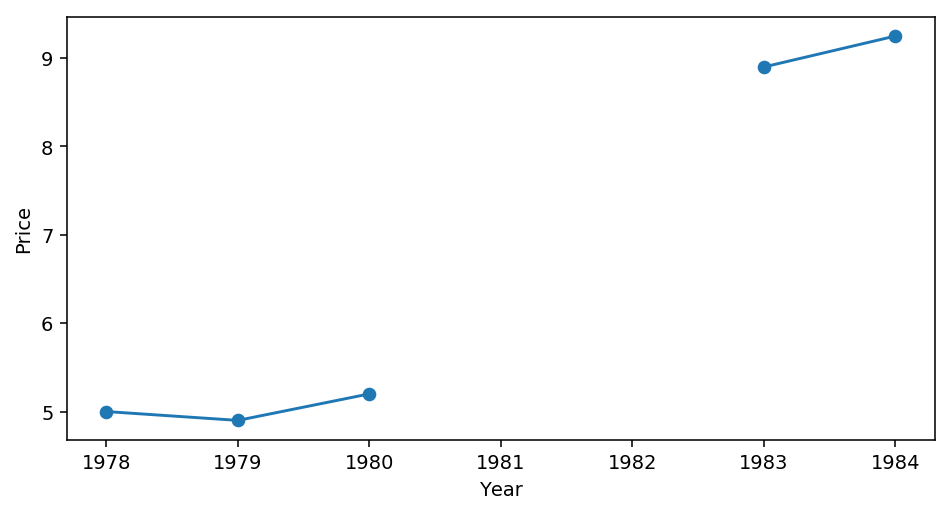

In [49]:
year = [1978, 1979, 1980, 1981, 1982, 1983, 1984]
price = [5.0, 4.9, 5.2, np.nan, np.nan, 8.9, 9.25]   # no data for 1981 or 1982

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(year, price, '-o')
ax.set_xlabel("Year")
ax.set_ylabel("Price")


## Roundoff and precision
Floating point operations can introduce **roundoff error**, because the operations involved have to quantize the results of computations. This can be subtle, because the precision of floating point numbers is variable according to their magnitude; unlike integers, where roundoff is always to the nearest whole number.

<img src="imgs/ieee754.png">
*[By Ghennessey - Own work, CC BY-SA 4.0, https://commons.wikimedia.org/w/index.php?curid=35324110]*

### If you take a standard deviation of a collection of values, does it matter if the values are stored?

In [50]:
import numpy as np
x = np.exp(np.random.uniform(-35,45,10000))
x_sorted = np.sort(x)
print("%.5f" % np.std(x))
print("%.5f" % np.std(x_sorted))

## a terrible order
## alternating largest and smallest
x_bad = np.stack([x_sorted[:len(x)//2], x_sorted[len(x)//2:][::-1]]).T.ravel()
print("%.5f" % np.std(x_bad))


2777030584086122496.00000
2777030584086122496.00000
2777030584086122496.00000


### Round off problems

In [51]:
print_float_html(1.0 + 1e-4) # ok
print_float_html(1.0 + 1e-8) # ok
print_float_html(1.0 + 1e-16) # exactly equal to one

In [52]:
print_float_html(1e9 + 1e-4) # ok
print_float_html(1e9 + 1e-8) # exactly equal to 1e9
print_float_html(1e9 + 1e-16) # exactly equal to 1e9

#### Repeated operations
This can be a real problem when doing repeated operations. Imagine adding dividends to a bank account every second (real time banking!)

In [53]:
balance = 100000000000 # Bill Gates' account

def accumulate_wealth(starting_balance, dividend_per_second, dtype=np.float64):
    balance = np.array(starting_balance, dtype=dtype)
    dividend_per_second = np.array(dividend_per_second, dtype=dtype)    
    seconds_in_month = 24*60*60*30
    # run one month's calculation
    for i in range(seconds_in_month):
        balance = balance + dividend_per_second
    
    print("Apparently earned: $%.2f" % (balance - starting_balance))
    print("Should have earned: $%.2f" % (seconds_in_month * dividend_per_second))
    

In [54]:
accumulate_wealth(balance, 0.00001) # got almost twice as much as it should have!

Apparently earned: $39.55
Should have earned: $25.92


In [55]:
accumulate_wealth(balance, 0.000001) # got nothing at all

Apparently earned: $0.00
Should have earned: $2.59


In [56]:
accumulate_wealth(balance, 0.01, dtype=np.float32)  # apparently lost money! (original balance wasn't exact in float32)

Apparently earned: $-2048.00
Should have earned: $25920.00


#### Financial operations
Moral of the story: **Never** use floating point operations for financial calculations. Use decimal formats, with precisely defined roundoff rules (if roundoff can occur) for financial operations.

### Roundoff error
While this might seem an unlikely scenario, adding repeated tiny offsets to enormous values is exactly the kind of thing that happens in lots of simulations; for example, plotting the trajectory of a satellite with small forces from solar wind acting upon it.

The ordering of operations can be important, with the general rule being to avoid operations of numbers of wildly different magnitudes. 
**This means, in some extreme cases, that the distributive and associative rules don't apply to floating point numbers!**

In [57]:
(1.e30 + 1.) - 1.e30 # wrong, severe roundoff error

In [58]:
(1.e30 - 1.e30) + 1. # no roundoff error

Some basic rules:
1. `x+y` will have large error if x and y have different magnitudes (magnitude error)
1. `x/y` will have large error if `y` is very small (division magnification)
1. `x-y` will have large error if `x~=y` (cancellation error)

In [59]:
print("Addition")
print(1.0 + 1.0) # ok
print(1.0 + 1e300) # bad, rule 1
print("Subtraction")
print(1000.0 - 1200.0) # ok
print(1000.0 - 1000.00000000000001) # bad, rule 4


Addition
2.0
1e+300
Subtraction
-200.0
0.0


### Allclose
Because of the roundoff errors in floating point numbers, whenever there are comparisons to be made between floating point numbers, it is not appropriate to test for precise equality. This code snippet illustrates the problem:

In [60]:
y = 0.1
z = 300000.0
x = y 
x = x + z
x = x - z

# x==y, right?
print(x==y)
print(x-y)

False
-2.3283069916502086e-11


In [61]:
# sometimes the error can be quite extreme, if we have a small value and a large value in one operation
x = y + z * z * z
x = x - z * z * z
print(x-y)
print(x)  ## uh oh, x has become 0!

-0.1
0.0


Instead, we **must** always compare floating point numbers by determining if their absolute difference is less than some threshold:
$$|x-y|<\epsilon$$

In [62]:
y = 0.1
z = 300000.0
x = y 
x = x + z
x = x - z

eps = 1e-8 # this threshold is often called epsilon but is not the same as machine epsilon!

# (1e-8 is not universal, but often reasonable for float64)
# in practice, the choice of epsilon will depend on the application and the operations performed
print(abs(x-y)<1e-8)

True


Testing if all elements of two arrays are within some tolerance is a standard array operation, which NumPy calls `np.allclose(x,y)`.

In [63]:
print(np.allclose(x,y)) 

True


In [64]:
x = np.full((8,8), 33341331514515.110)
y = np.full((8,8), 7452.15415)
z = (x*y*y*y) / (y*y*y)
print(x==z)

[[False False False False False False False False]
 [False False False False False False False False]
 [False False False False False False False False]
 [False False False False False False False False]
 [False False False False False False False False]
 [False False False False False False False False]
 [False False False False False False False False]
 [False False False False False False False False]]


In [65]:
print(np.all(x==z))

False


In [66]:
print(np.allclose(x,z))

True


**NEVER USE EQUALITY ON FLOATING POINT VALUES OR ARRAYS!** (unless you are explicitly testing for roundoff error and know what you are doing)

### Machine precision and $\epsilon$
Just how bad (or good) are floating point numbers at representing real numbers within their range? How close is $\text{float}(\pi)$ to $\pi$?

Floating point representations have a **relative error**, defined by:
$$
\epsilon = \frac{|\text{float}(x)-x|}{|x|}, \examinable
$$
the absolute difference between a floating point number and its real counterpart, normalised by the magnitude of the real number.

IEEE 754 guarantees that this error is always less than
$$
\epsilon \leq \frac{1}{2}2^{-t}, \epsilon \leq 2^{-t-1},  \examinable
$$
where $t$ is the number of bits dedicated to the mantissa, excluding the implied 1.

This guarantee applies to both *storage* of numbers (the relative error will never be greater than $\epsilon$) and to *operations* on numbers (that roundoff error in computations will be have relative error $<\epsilon$).

For `float64`, $\epsilon=2^{-53} \approx 1.1\times 10^{16}$.

In [67]:
# we can ask NumPy to print these statistics for us
# note the epsilon term epsneg
print(np.finfo(np.float64))

Machine parameters for float64
---------------------------------------------------------------
precision =  15   resolution = 1.0000000000000001e-15
machep =    -52   eps =        2.2204460492503131e-16
negep =     -53   epsneg =     1.1102230246251565e-16
minexp =  -1022   tiny =       2.2250738585072014e-308
maxexp =   1024   max =        1.7976931348623157e+308
nexp =       11   min =        -max
---------------------------------------------------------------



In [68]:
# check this is indeed the value we expect to see
t = 52
2.0**(-t-1)

## NumPy types
Unless you specify a different type (e.g. with `dtype=` when calling `np.array` or `np.zeros`, etc.), arrays will be `float64` if they have any floating point value when created, and `int32` otherwise.

An array can be converted using `.astype()`, which will convert the array elements to the specified type.

x = np.array([1,2,3]) # no floats, this will be int32
print(x.dtype)

In [69]:
x = np.array([1,2,3], dtype=np.int8) # force to int8
print(x.dtype)

int8


In [70]:
y = np.array([1.0, 2, 3])  # at least one float, will be float64
print(y.dtype)

float64


In [71]:
x_float = x.astype(np.float64)
print(x_float.dtype)
print(x_float)

float64
[1. 2. 3.]


In [72]:
x_float32 = x.astype(np.float32)
print(x_float32.dtype)
print(x_float32)

float32
[1. 2. 3.]


# Resources for this lecture
* **From Python to Numpy** http://www.labri.fr/perso/nrougier/from-python-to-numpy/ *recommended reading*

---

* **Floating point numbers** http://pmihaylov.com/floating-point-numbers/ (floats)
* **What Every Computer Scientist Should Know About Floating Point Numbers** http://docs.oracle.com/cd/E19957-01/806-3568/ncg_goldberg.html

## Advanced (beyond this course)
* **Advanced NumPy** http://www.scipy-lectures.org/advanced/advanced_numpy/
* **NumPy tricks** http://arogozhnikov.github.io/2015/09/30/NumpyTipsAndTricks2.html and http://arogozhnikov.github.io/2015/09/29/NumpyTipsAndTricks1.html